### Validation
This notebook will be validating inversion results with OIB of the year 2019 

All inversion results are in '/images' folder

OIB data can be found in OIB folder that has been extracted from https://nsidc.org/data/nsidc-0708/versions/1 and binned to a 25km grid 

grids can be found in parent directory labelled 'new_.._25km'

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import chain
from mpl_toolkits.basemap import Basemap
import netCDF4 as nc 
from sklearn.metrics import r2_score

In [2]:

def draw_map(m, scale=0.2):
    # draw a shaded-relief image
    # m.shadedrelief(scale=scale)
    m.drawlsmask(land_color='gray',ocean_color='white',lakes=True)
    # lats and longs are returned as a dictionary
    lats = m.drawparallels(np.linspace(-90, 90, 13))
    lons = m.drawmeridians(np.linspace(-180, 180, 13))

    # keys contain the plt.Line2D instances
    lat_lines = chain(*(tup[1][0] for tup in lats.items()))
    lon_lines = chain(*(tup[1][0] for tup in lons.items()))
    all_lines = chain(lat_lines, lon_lines)
    
    # cycle through these lines and set the desired style
    for line in all_lines:
        line.set(linestyle='-', alpha=0.3, color='w')

def mask_observations(observations, inversion):
    new_inversion = np.copy(inversion)
    for i in range(len(observations)):
        for j in range(len(observations[0])):
            if np.isnan(observations[i][j]):
                new_inversion[i][j] = np.nan
    return new_inversion

def pearson(inverse, OIB):
    # pearson coefficient
    ydata = np.array(inverse)
    yfit = np.array(OIB)

    ydata_mean = np.mean(ydata)
    yfit_mean = np.mean(yfit)

    data_diff = ydata - ydata_mean
    fit_diff = yfit - yfit_mean

    top = np.sum( (data_diff) * (fit_diff) )

    bottom = np.sqrt( np.sum(data_diff**2) * np.sum(fit_diff**2) )

    r = top/bottom

    return r



In [3]:
def filter_data(oib_file, oib_ice, oib_snow, ice_file, ice, snow_file, snow, lon, lat, ak_file, cs_file):
    ''' filters out the data that is available in both OIB and inversion files'''
    #loading OIB data
    OIB = nc.Dataset(oib_file)
    SIT = OIB.variables['Sea Ice Thickness'][:,:]
    SD = OIB.variables['Snow Depth'][:,:]
    long = OIB.variables['Longitude'][:,:]
    lati = OIB.variables['Latitude'][:,:]

    # loading inversion and freeboard data
    ak = np.load(ak_file)
    cs = np.load(cs_file)
    inverse_ice = np.loadtxt(ice_file)
    inverse_snow = np.loadtxt(snow_file)
    inverse_snow = mask_observations(ak, inverse_snow) # mask the observations to actual Altika tracks
    inverse_ice = mask_observations(ak, inverse_ice)


    for i in range(360):
        for j in range(360):
            if not (SIT.mask[i][j]) and not np.isnan(inverse_snow[i][j]):
                oib_ice.append(SIT.data[i][j])
                oib_snow.append(SD.data[i][j])
                ice.append(inverse_ice[i][j])
                snow.append(inverse_snow[i][j])
                lon.append(long.data[i][j])
                lat.append(lati.data[i][j])
    

    OIB.close() 

In [4]:
import os

def extract_dates(folder_path):
    date = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.npy_snow') and not filename.endswith('.npy_ice_stddev'):
            info = filename.split('_')[4].split('.')[0] #split by '_' and remove .npy
            date.append(info)
    date.sort()
    return date

def extract_files(folder_path, dates, type):
    matching_files = []
    for date in dates:
        year = int(date[:4])  # Extract the year from the date
        initial_year = f"{year-1}-{year}"
        filename = f"FB_interp_{initial_year}_25km_{date}{type}"
        file_path = os.path.join(folder_path, filename)
        if os.path.exists(file_path):
            matching_files.append(file_path)
    return matching_files

def extract_OIB(folder_path, dates):
    files = []
    for date in dates:
        filename = f'{date}.nc'
        file_path = os.path.join(folder_path, filename)

        if os.path.exists(file_path):
            files.append(file_path)

    return files


In [5]:
date = extract_dates('images/')

#file paths
snow_files = extract_files('images/', date, '.npy_snow')
ice_files = extract_files('images/', date, '.npy_ice')
OIB_files = extract_OIB('../../OIB/25km_ease_binned_data', date)
ak_files = extract_files('../carmen/daily_numpys/AK_CPOM/', date,'.npy')
cs_files = extract_files('../carmen/daily_numpys/CS2_CPOM/', date, '.npy')

In [6]:
# Initialize arrays to store filtered data
OIB_ice = []
OIB_snow = []
lon_data = []
lat_data = []
snow_data = []
ice_data = []

# Iterate through each file and filter the data
for i in range(len(date)):
    filter_data(OIB_files[i], OIB_ice, OIB_snow, ice_files[i], ice_data, snow_files[i], snow_data, lon_data, lat_data, ak_files[i], cs_files[i])

In [7]:
r_ice = pearson(ice_data, OIB_ice)
r_snow = pearson(snow_data, OIB_snow)

/tmp/ipykernel_328076/2069257697.py:41: RuntimeWarning: invalid value encountered in scalar divide
  r = top/bottom


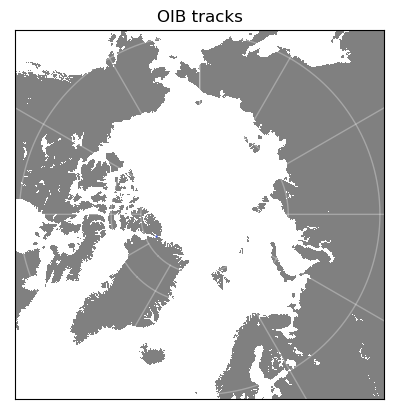

In [8]:
plt.figure()
plt.title("OIB tracks")
m = Basemap(projection='lcc', resolution=None, lat_0=-90, lon_0=0, lat_1=89.9, lon_1=180, width=0.7E7, height=0.7E7)
draw_map(m)
m.scatter(lon_data, lat_data, latlon=True, alpha=1, s=0.5, c=OIB_snow, cmap="coolwarm", vmin=0, vmax=6)
plt.show()

In [9]:
def analyse (calculated_data, validation_data):
    error = np.array(calculated_data) - np.array(validation_data)
    md = np.mean(error)
    rmse = np.sqrt( np.mean( (error)**2 ))
    r2 = r2_score(validation_data, calculated_data)

    # Calculate slope and y-intercept
    slope, intercept = np.polyfit(validation_data, calculated_data, 1)

    return md, rmse, r2, slope, intercept

/home/sraz/.conda/envs/packages/lib/python3.8/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/tmp/ipykernel_328076/1551287263.py:6: RankWarning: Polyfit may be poorly conditioned
  md, rmse, r2, slope, intercept = analyse(data, OIB_ice)


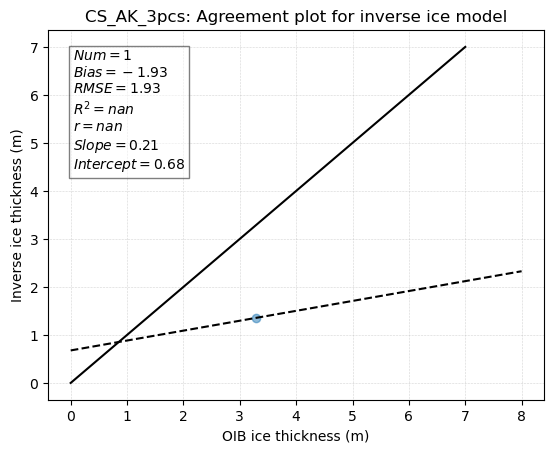

In [10]:
# analysis for ice

data = np.array(ice_data)
OIB_ice = np.array(OIB_ice)
# Perform analysis
md, rmse, r2, slope, intercept = analyse(data, OIB_ice)

plt.figure()
plt.title('CS_AK_3pcs: Agreement plot for inverse ice model')

plt.grid(linestyle='dotted', linewidth ='0.4')
plt.scatter(OIB_ice, data, alpha=0.5)
plt.plot([0,7] , [0,7], 'k-')
plt.xlabel('OIB ice thickness (m)')
plt.ylabel('Inverse ice thickness (m)')

textstr = '\n'.join((
    rf'$Num = {len(ice_data)}$',
    rf'$Bias={md:.2f}$',
    rf'$RMSE={rmse:.2f}$',
    rf'$R^2={r2:.2f}$',
    rf'$r = {r_ice:.2f}$',
    rf'$Slope = {slope:.2f}$',
    rf'$Intercept = {intercept:.2f}$'))
box_props = dict(boxstyle='square', facecolor= 'white', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=box_props)

# Plot linear regression line
x_values = np.array([0,8])
y_values = slope * x_values + intercept
plt.plot(x_values, y_values, 'k--', label='Linear Regression')

plt.show()

/home/sraz/.conda/envs/packages/lib/python3.8/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/tmp/ipykernel_328076/646842366.py:5: RankWarning: Polyfit may be poorly conditioned
  md, rmse, r2, slope, intercept = analyse(data, OIB_snow)


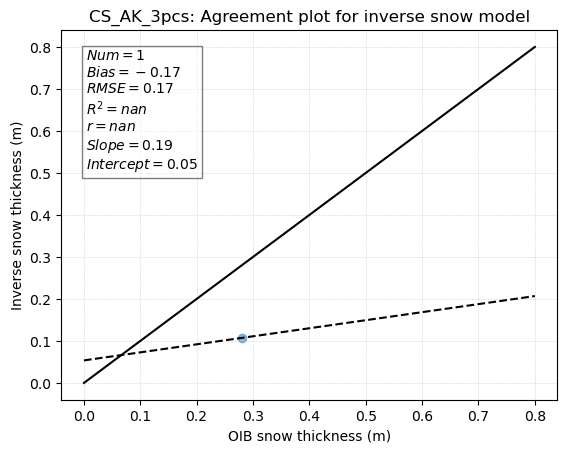

In [11]:
# analysis for snow
data = np.array(snow_data)
OIB_snow = np.array(OIB_snow)
# Perform analysis
md, rmse, r2, slope, intercept = analyse(data, OIB_snow)


plt.figure()
plt.title('CS_AK_3pcs: Agreement plot for inverse snow model')

# Add grids
plt.grid(linestyle='dotted', linewidth ='0.4')
plt.scatter(OIB_snow, snow_data, alpha=0.5)
plt.plot([0,0.8] , [0,0.8], 'k-')
plt.xlabel('OIB snow thickness (m)')
plt.ylabel('Inverse snow thickness (m)')

textstr = '\n'.join((
    rf'$Num = {len(ice_data)}$',
    rf'$Bias={md:.2f}$',
    rf'$RMSE={rmse:.2f}$',
    rf'$R^2={r2:.2f}$',
    rf'$r = {r_snow:.2f}$',
    rf'$Slope = {slope:.2f}$',
    rf'$Intercept = {intercept:.2f}$'))
box_props = dict(boxstyle='square', facecolor= 'white', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=box_props)

# Plot linear regression line
x_values = np.array([0,0.8])
y_values = slope * x_values + intercept
plt.plot(x_values, y_values, 'k--', label='Linear Regression')

plt.show()